# MDA 2022 - Project
## Abolfazl Yarian (400205641)
-----------------------------------------------------------------

## Initializing Spark and read data

In [84]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
import itertools

In [85]:
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
spark = SparkSession \
    .builder \
    .appName("MDA2022-Project") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",StringType(),True), \
        StructField("FINAL_CAR_KEY",StringType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

In [86]:
# read traffic data as a dataframe
df = spark.read.csv("MDA2022ProjectData.csv", header=True, schema=schema)

# re???????؟؟؟؟؟؟؟؟؟؟؟؟
df = df.filter((df.SYSTEM_ID == 84) | (df.SYSTEM_ID == 283) | (df.SYSTEM_ID == 284))
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010047|      284|       63455590|     63455590|               6|       161|2021-12-22 00:59:30|
|   22010054|      284|       63566637|     64111706|               7|       161|2021-12-22 01:24:58|
|   22010057|      284|       63653636|     63653636|               6|       161|2021-12-22 00:46:37|
|   22010039|      284|       63562975|     64111706|               7|       161|2021-12-22 00:27:32|
|   22010053|      284|       63634047|     64111706|               7|       161|2021-12-22 01:29:24|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



The 22nd and 23rd of January, which are Thursday and Friday, have been removed from the dataset. As a result of this work, I have data for four weeks and the dataset is balanced

In [87]:
data_rdd = df.rdd.filter(lambda x: (x['PASS_DAY_TIME'].date().day != 22) and (x['PASS_DAY_TIME'].date().day != 23))

In [88]:
# sample = data_rdd1.sample(withReplacement=False, fraction=0.01, seed=10).collect()
# data_rdd = sc.parallelize(sample)

# 1 - Traffic Histograms:

In [89]:
# create a RDD with key=car_key and values=(deviceCode, passDayTime) : list of device codes that captured the car with time
# We sorted the values by time to compute pairs camera 
car_traffic_rdd = data_rdd.map(lambda x: (x['ORIGINE_CAR_KEY'],(x['DEVICE_CODE'], x['PASS_DAY_TIME'] )))\
                            .groupByKey().mapValues(list)\
                            .map(lambda x: (x[0], sorted(x[1], key=lambda y: y[1])))

In [90]:
car_traffic_rdd.take(1)

[('52404132',
  [(900202, datetime.datetime(2021, 12, 28, 13, 56, 38)),
   (900207, datetime.datetime(2021, 12, 28, 14, 1, 48)),
   (900225, datetime.datetime(2021, 12, 28, 14, 6, 32)),
   (900222, datetime.datetime(2021, 12, 28, 19, 47, 28)),
   (900224, datetime.datetime(2021, 12, 28, 19, 56, 43)),
   (900222, datetime.datetime(2021, 12, 28, 20, 19, 15)),
   (900202, datetime.datetime(2021, 12, 30, 10, 45, 30)),
   (900207, datetime.datetime(2021, 12, 30, 10, 50, 54)),
   (900225, datetime.datetime(2021, 12, 30, 10, 54, 11)),
   (900222, datetime.datetime(2021, 12, 30, 20, 10, 12)),
   (900225, datetime.datetime(2021, 12, 31, 13, 36, 15)),
   (900222, datetime.datetime(2021, 12, 31, 20, 20, 21)),
   (900202, datetime.datetime(2022, 1, 1, 12, 58, 51)),
   (900207, datetime.datetime(2022, 1, 1, 13, 8, 48)),
   (900225, datetime.datetime(2022, 1, 1, 13, 12, 46)),
   (900222, datetime.datetime(2022, 1, 1, 20, 56, 14)),
   (900202, datetime.datetime(2022, 1, 2, 12, 27, 10)),
   (900207, d

In [91]:
# function to find adjacency devices (pairs of adjacent devices) whose passing time is less than 15 minutes
# It returns a tuple with key=day of pass and values=(pair of adjacent devices) 
def adjacencyDevice(device_time):
    adj_device = []
    diff = np.diff(np.array(device_time)[:,1])
    for i in range(len(diff)):
        if (device_time[i+1][1].hour >= 6) and (device_time[i+1][1].hour < 9) or \
           (device_time[i+1][1].hour >= 12) and (device_time[i+1][1].hour < 14) or \
           (device_time[i+1][1].hour >= 17) and (device_time[i+1][1].hour < 21):
            weight = 25
        else:
            weight = 15

        if diff[i].total_seconds() < weight*60:
            date = device_time[i][1].day
            adj_device.append((date,(device_time[i][0], device_time[i+1][0])))
            # adj_device.append((date,'-'.join((str(device_time[i][0]), str(device_time[i+1][0])))))
    
    return adj_device

> * If you are show the pair of cars with same item (loop node), you should remove  `x[0][1][0] != x[0][1][1]` in next cell

In [92]:
# create a RDD with key=(day pass, adjacent device) and value=The number of cars passing below the adjacent camera
# It is used to find which routes are busy
#
adjdevice_traffic_rdd = car_traffic_rdd.mapValues(adjacencyDevice).filter(lambda x: len(x[1]) !=0 )\
                                        .flatMap(lambda x: x[1]).map(lambda x: (x,1))\
                                        .reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending=False)\
                                        .filter(lambda x: x[1] > 500 and x[0][1][0] != x[0][1][1] )     # <-----

adjdevice_traffic_rdd.take(3)

[((30, (900212, 900244)), 63343),
 ((13, (900212, 900244)), 62088),
 ((31, (900212, 900244)), 61102)]

In [93]:
# create a RDD with key=(day pass) and value=list of (adjacent device,The number of cars passing below the adjacent camera) and sorted by number of passing car
# we sort the values to find busy route 
adjdevice_traffic_perday_rdd = adjdevice_traffic_rdd.map(lambda x: (x[0][0], (x[0][1], x[1]))).groupByKey().mapValues(list)\
                                                        .sortBy(lambda x: x[0]) #TODO add to sort

devicepair_traffic_perday_list = adjdevice_traffic_perday_rdd.collect()
devicepair_traffic_perday_list

[(1,
  [((900212, 900244), 57187),
   ((900142, 900212), 24481),
   ((100700804, 100700834), 11631),
   ((900268, 900225), 11322),
   ((900236, 100700841), 11212),
   ((900227, 900269), 10415),
   ((900191, 900218), 8653),
   ((900101, 900212), 7969),
   ((900269, 900259), 7807),
   ((900244, 100700839), 7672),
   ((900213, 900212), 7646),
   ((900234, 22010118), 7490),
   ((900212, 900273), 7027),
   ((900256, 900215), 6412),
   ((900248, 900272), 6037),
   ((900202, 900207), 6036),
   ((900244, 900102), 5960),
   ((900101, 900268), 5644),
   ((900208, 900244), 5376),
   ((900223, 100701100), 4556),
   ((900259, 100700841), 4466),
   ((22009972, 900215), 4200),
   ((22009971, 22009972), 4027),
   ((900207, 900225), 3941),
   ((900185, 900242), 3888),
   ((900142, 100700853), 3887),
   ((900235, 100700871), 3880),
   ((900264, 900213), 3797),
   ((900236, 900212), 3741),
   ((900255, 900236), 3700),
   ((900102, 100701130), 3652),
   ((22009977, 900268), 3606),
   ((900185, 100700864),

In [94]:
# all top car in all day
all_adjdevice_list = adjdevice_traffic_perday_rdd.flatMap(lambda x: x[1]).reduceByKey(lambda x,y:x+y).sortBy(lambda x: x[1], ascending=False).collect()
all_adjdevice_list

[((900212, 900244), 1540914),
 ((900142, 900212), 662161),
 ((100700804, 100700834), 318500),
 ((900236, 100700841), 312403),
 ((900268, 900225), 302194),
 ((900227, 900269), 268483),
 ((900191, 900218), 236398),
 ((900244, 100700839), 216713),
 ((900213, 900212), 203333),
 ((900101, 900212), 197447),
 ((900212, 900273), 193214),
 ((900269, 900259), 190184),
 ((900244, 900102), 160279),
 ((900256, 900215), 150392),
 ((900223, 100701100), 147720),
 ((900101, 900268), 141527),
 ((900152, 900142), 135574),
 ((900208, 900244), 126460),
 ((22009971, 22009972), 121366),
 ((900202, 900207), 121081),
 ((900259, 100700841), 115346),
 ((22009972, 900215), 113948),
 ((900236, 900212), 110948),
 ((900185, 900242), 110905),
 ((900142, 100700853), 110427),
 ((900235, 100700871), 108000),
 ((900102, 100701130), 101290),
 ((900264, 900213), 101009),
 ((900248, 900272), 100427),
 ((900207, 900225), 99706),
 ((900242, 900241), 96072),
 ((22009977, 900268), 95938),
 ((900185, 100700864), 93533),
 ((90025

## Plot Histogram

In [95]:
devicepair = adjdevice_traffic_rdd.map(lambda x:x[0][1]).distinct().collect()
print("number of unique device pair (link) with more than 500 passing : ", len(devicepair))

number of unique device pair (link) with more than 500 passing :  398


In [96]:
# top 40 of frequent adjacent device
freq_pair = [pair[0] for pair in all_adjdevice_list[2:40+2]]
freq_pair

[(100700804, 100700834),
 (900236, 100700841),
 (900268, 900225),
 (900227, 900269),
 (900191, 900218),
 (900244, 100700839),
 (900213, 900212),
 (900101, 900212),
 (900212, 900273),
 (900269, 900259),
 (900244, 900102),
 (900256, 900215),
 (900223, 100701100),
 (900101, 900268),
 (900152, 900142),
 (900208, 900244),
 (22009971, 22009972),
 (900202, 900207),
 (900259, 100700841),
 (22009972, 900215),
 (900236, 900212),
 (900185, 900242),
 (900142, 100700853),
 (900235, 100700871),
 (900102, 100701130),
 (900264, 900213),
 (900248, 900272),
 (900207, 900225),
 (900242, 900241),
 (22009977, 900268),
 (900185, 100700864),
 (900255, 900236),
 (900234, 22010118),
 (900266, 100700862),
 (900101, 100700853),
 (900225, 900223),
 (900225, 900269),
 (900241, 22010117),
 (900226, 900269),
 (900243, 900259)]

In [97]:
def histogramPlot(dayshift):
    plt.figure(figsize=(25,12))
    map_day=['Saturday','Sunday', 'Monday', 'Tuesday','Wednesday','Thursday','Friday']
    for day in range(7):
        plt.subplot(2,4,day+1)
        plt.subplots_adjust( hspace=0.6)
        pairs = [['-'.join((str(i[0]), str(i[1]))), 0] for i in freq_pair]
        for i in devicepair_traffic_perday_list[dayshift+day][1]:
            if i[0] in freq_pair:
                pair = '-'.join((str(i[0][0]), str(i[0][1])))
                pass_pair = i[1]
                pairs[freq_pair.index(i[0])] = [pair, pass_pair]
        
        data = np.array(pairs)
        plt.bar(x=data[:,0],height=list(map(int, data[:,1])))
        plt.xticks(rotation=90, fontsize=6)
        plt.ylim((0,15000))
        plt.title(map_day[day%7]+ f" - {1+dayshift+day} January 2022" + "\n sum of pass in top camera pair = "+str(sum(list(map(int, data[:,1])))))

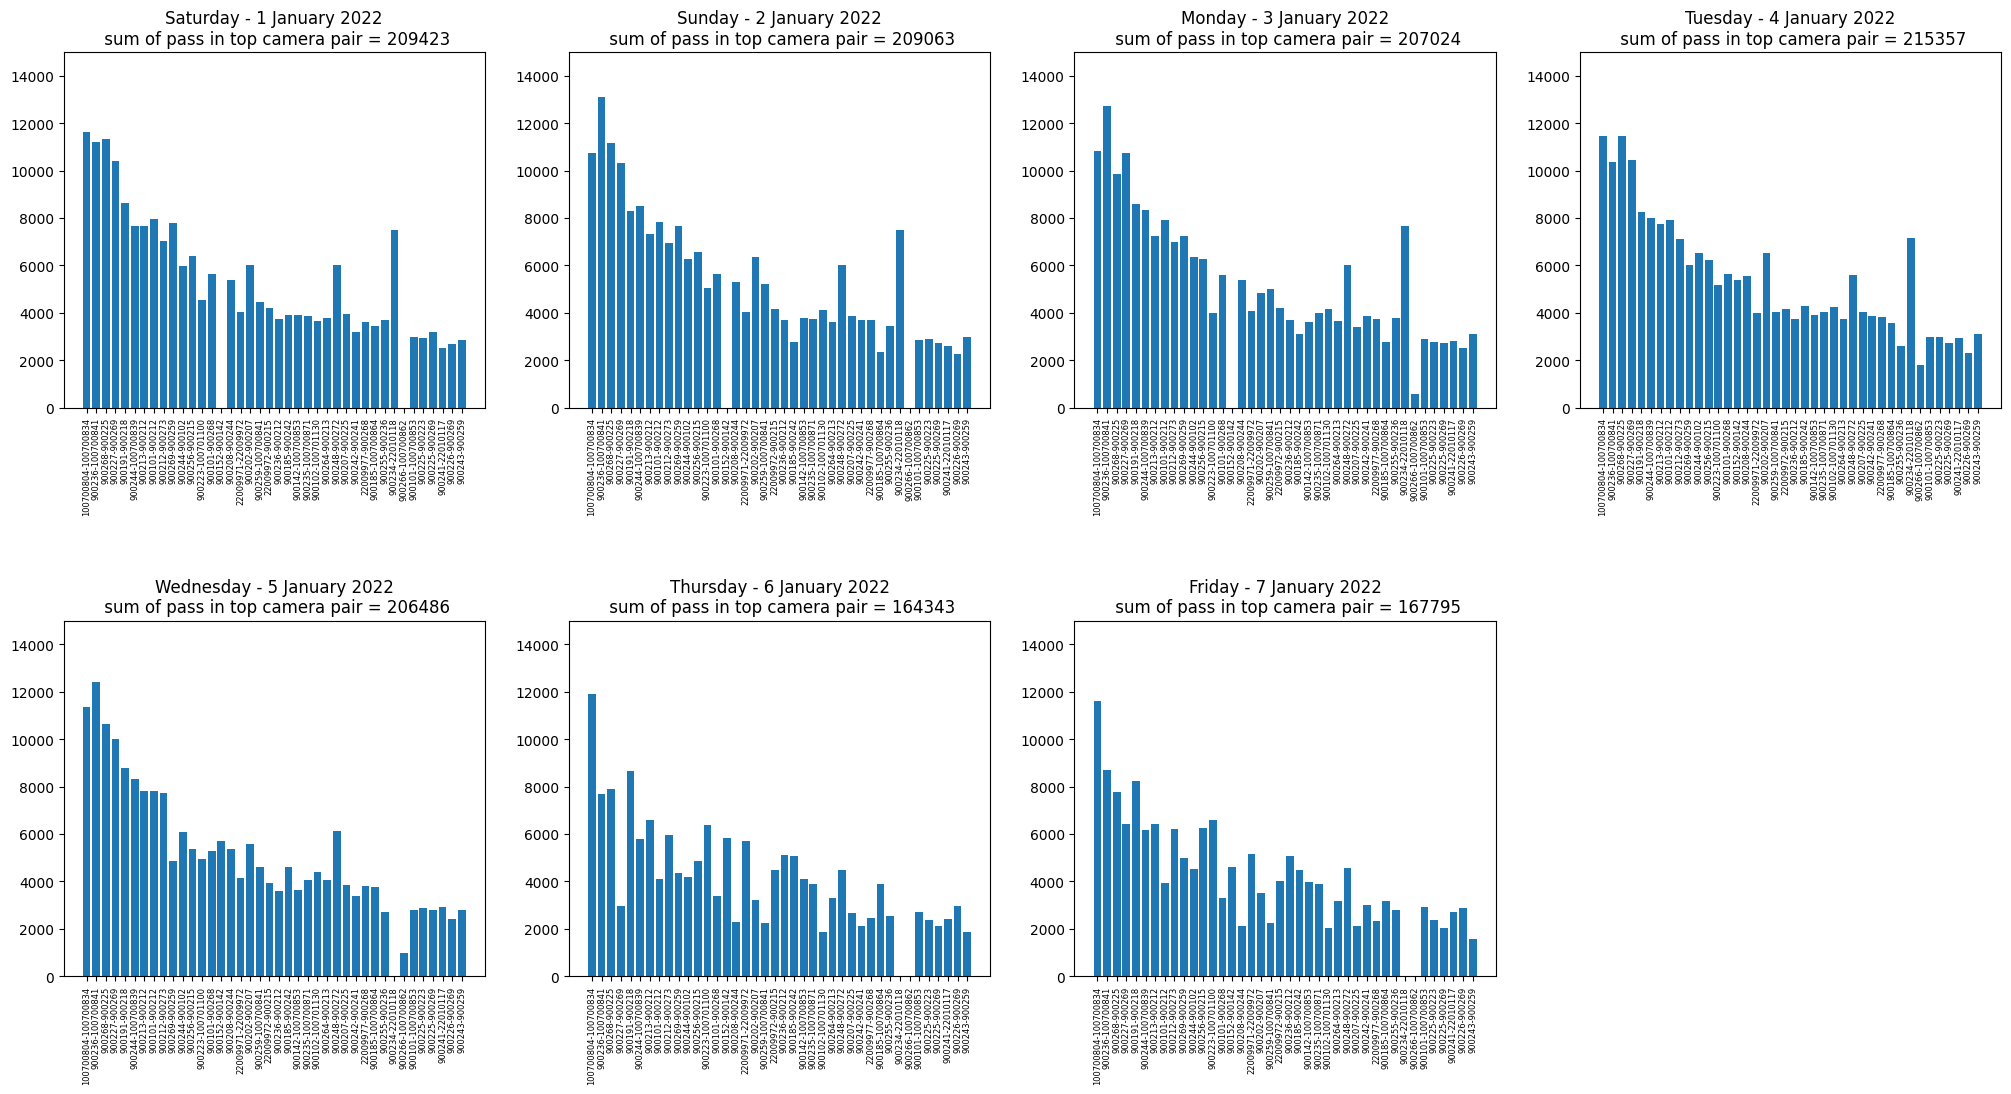

In [98]:
histogramPlot(0)

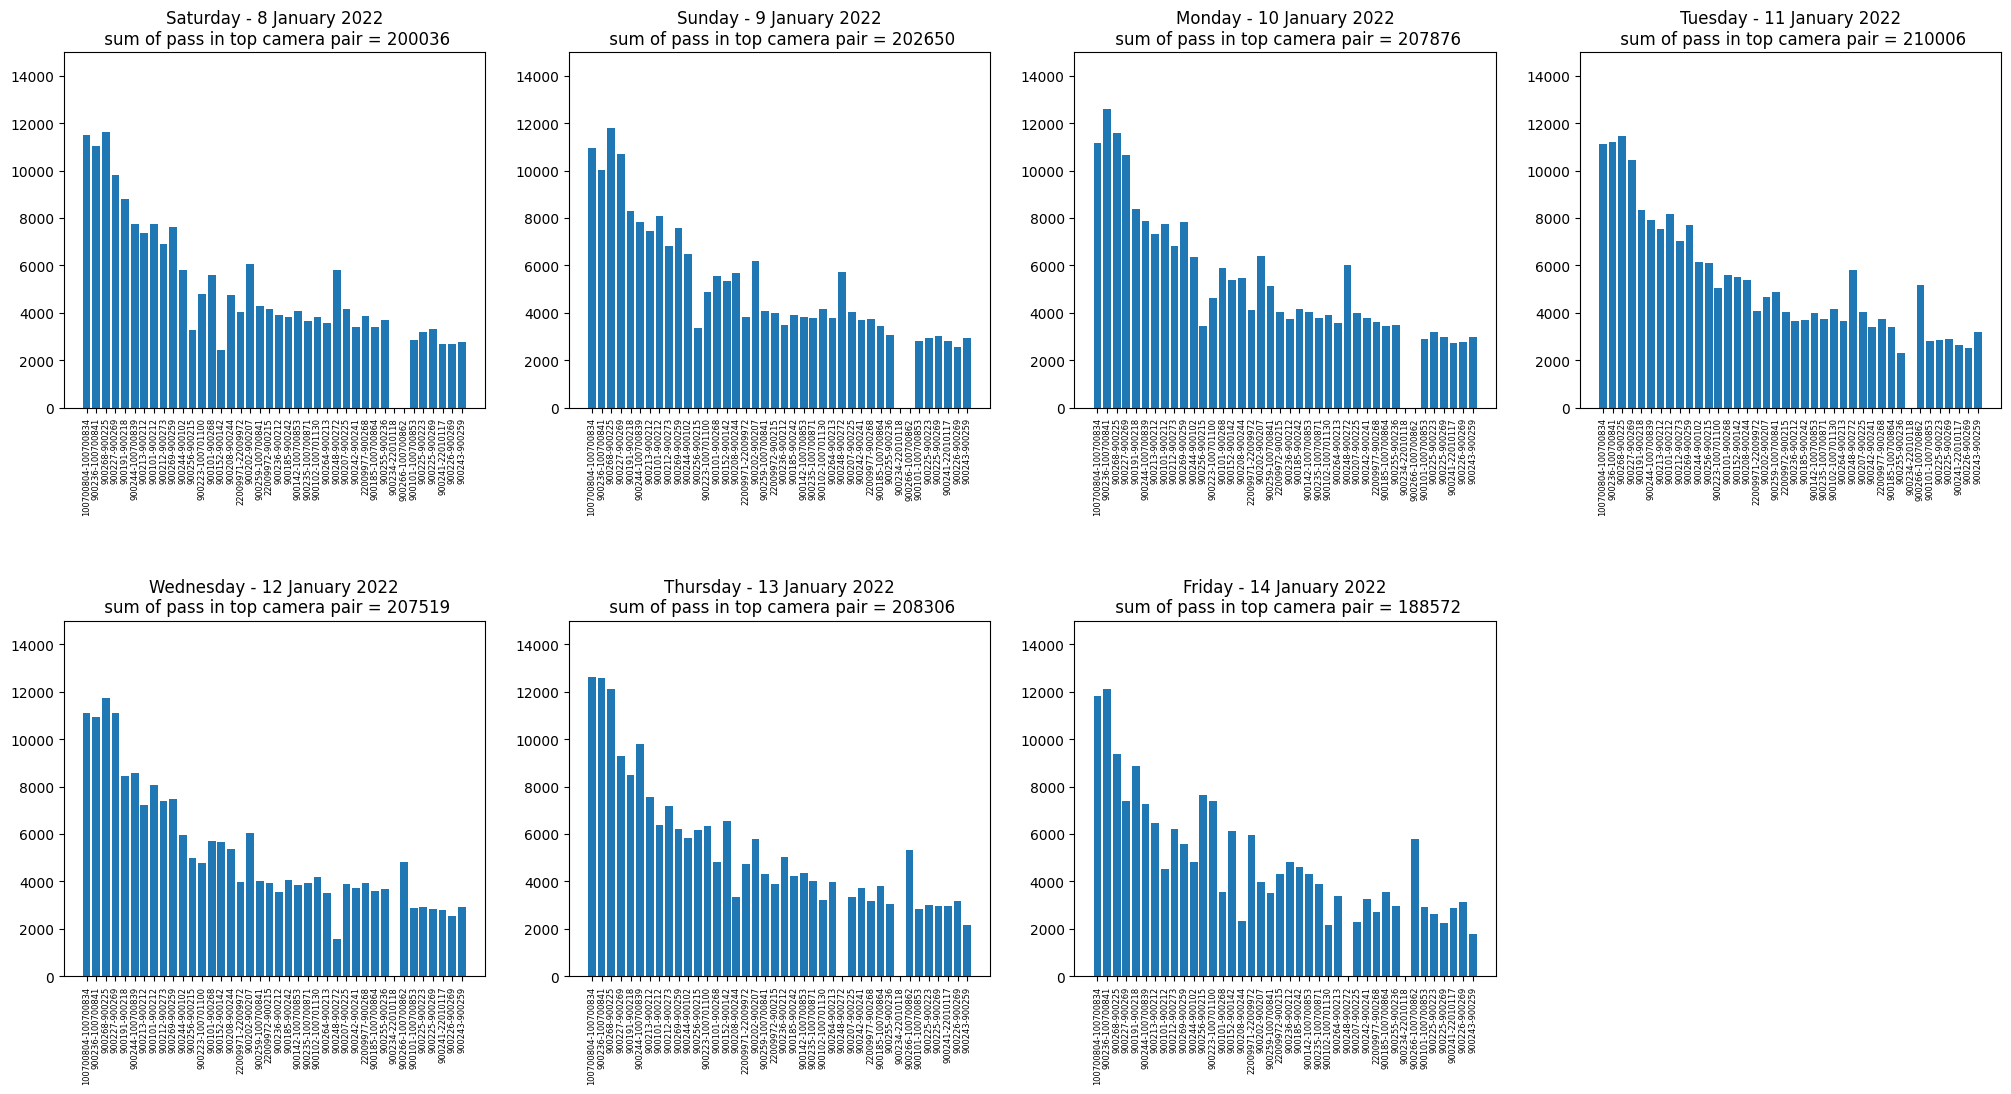

In [99]:
histogramPlot(7)

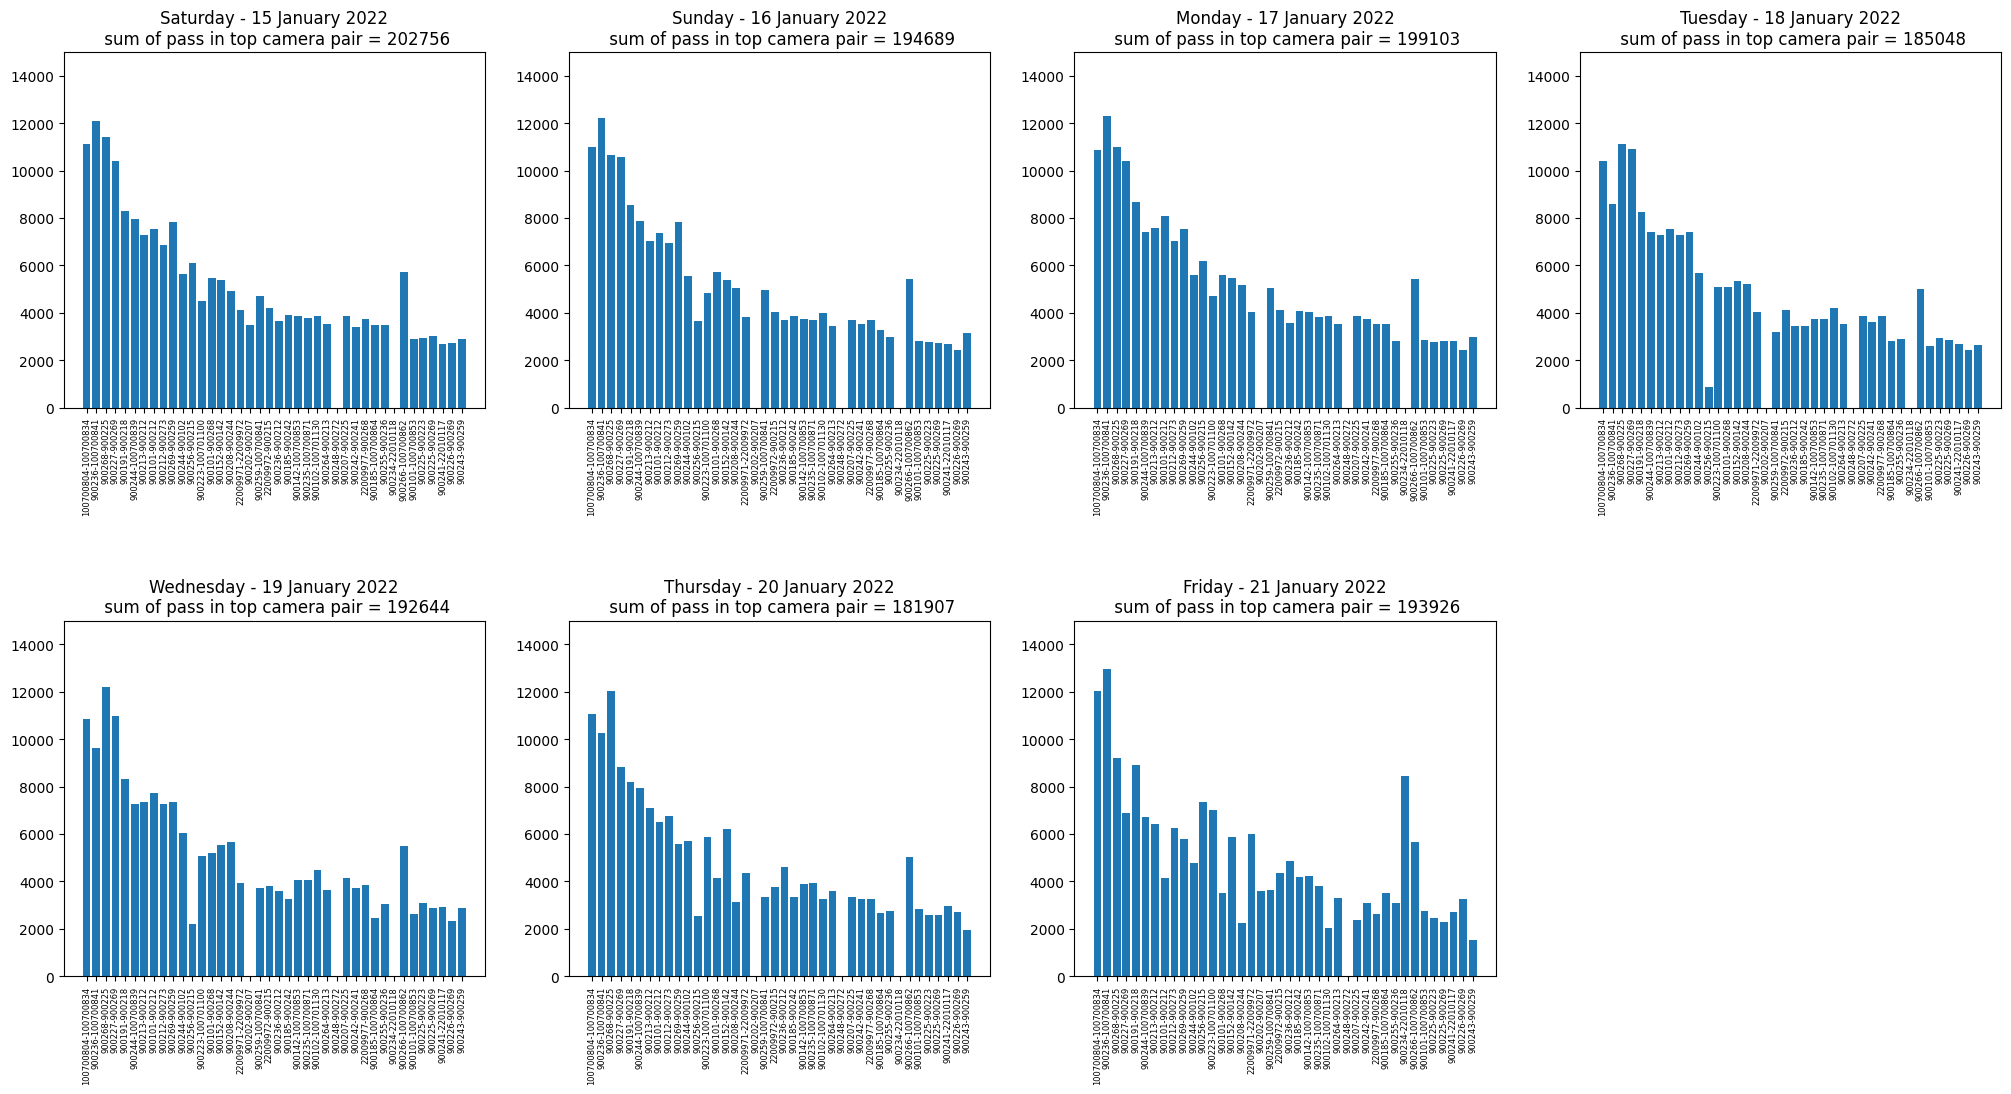

In [100]:
histogramPlot(7+7)

### ***Optional*** : Create a gif

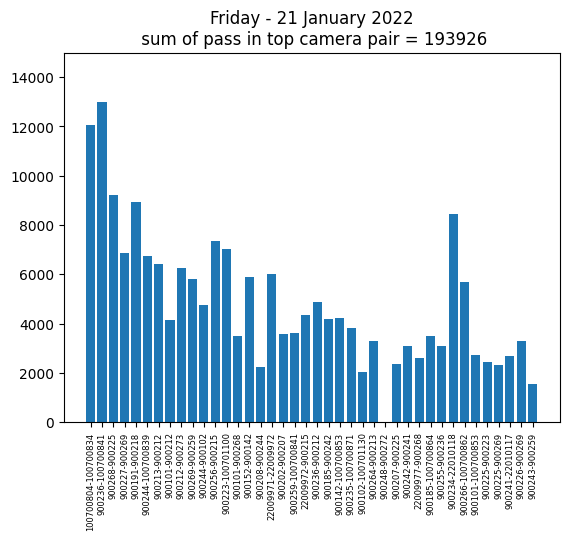

In [101]:
from matplotlib.animation import FuncAnimation, PillowWriter
map_day=['Saturday','Sunday', 'Monday', 'Tuesday','Wednesday','Thursday','Friday']
fig,ax = plt.subplots()
plt.subplots_adjust( hspace=0.7)

def animate(day):
# for day in range(cycle):
    ax.clear()    
    pairs = [['-'.join((str(i[0]), str(i[1]))), 0] for i in freq_pair]
    for i in devicepair_traffic_perday_list[day][1]:
        if i[0] in freq_pair:
            pair = '-'.join((str(i[0][0]), str(i[0][1])))
            pass_pair = i[1]
            pairs[freq_pair.index(i[0])] = [pair, pass_pair]
    
    data = np.array(pairs)
    dsss = ax.bar(x=data[:,0],height=list(map(int, data[:,1])))
    plt.xticks(rotation=90, fontsize=6)
    plt.ylim((0,15000))
    plt.title(map_day[day%7] + f" - {1+day} January 2022" + "\n sum of pass in top camera pair = "+str(sum(list(map(int, data[:,1])))))
    return dsss

ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=21)    
ani.save("pass_day_40pair.gif", dpi=300, writer=PillowWriter(fps=1))

## ***Optional*** : Plot Graph 

In [102]:
# traffic graph in all day of january
all_links = []
for day,pairs in devicepair_traffic_perday_list:
    l = [i[0] for i in pairs]
    all_links.extend(l)

In [103]:
# traffic graph in each day of january
day_links = []
for day,pairs in devicepair_traffic_perday_list:
    l = [i[0] for i in pairs]
    day_links.append(l)

In [104]:
len(all_links)

7423

Graph Density =  0.025711468019160327


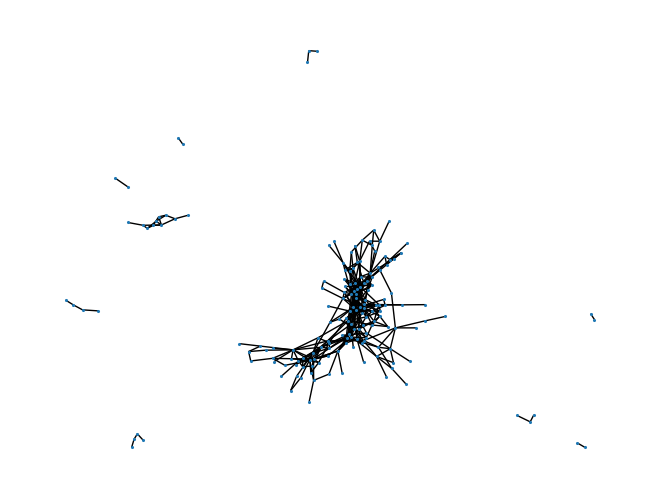

In [105]:
import networkx as nx
# plot traffic graph
G = nx.Graph()
G.add_edges_from(all_links)
print("Graph Density = ", nx.density(G))
nx.draw(G, with_labels=False, node_size = 1.5)
plt.savefig('pics/traffic_graph')
G.clear_edges()

Graph Density =  0.03617432374409618


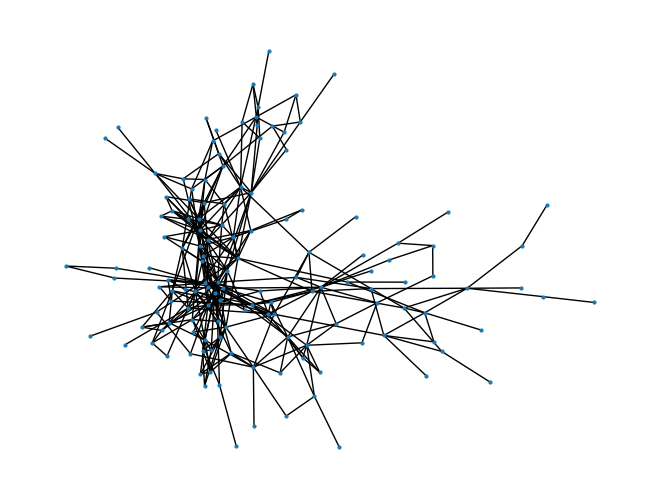

In [106]:
# largest connected graph in traffic Graph
G = nx.Graph()
G.add_edges_from(all_links)
innerTrafficGraph = max(nx.connected_components(G), key=len)
G2 = G.subgraph(innerTrafficGraph)
print("Graph Density = ", nx.density(G2))
nx.draw(G2, with_labels=False, node_size = 4)
plt.savefig(f'pics/inner_connected_traffic_graph', dpi=1000)

In [107]:
density = []
for i in range(21):
    G = nx.Graph()
    G.add_edges_from(day_links[i])
    innerTrafficGraph = max(nx.connected_components(G), key=len)
    G2 = G.subgraph(innerTrafficGraph)
    density.append((nx.density(G2), i+1))

In [68]:
# density in each day of january
sorted(density, key=lambda x: x[0])

[(0.03230479501665942, 7),
 (0.032714412024756855, 6),
 (0.03278688524590164, 14),
 (0.03375350140056022, 21),
 (0.03397597977243995, 20),
 (0.03404067197170645, 18),
 (0.03429752066115702, 13),
 (0.034453781512605045, 16),
 (0.03489531405782652, 1),
 (0.03489531405782652, 8),
 (0.03489531405782652, 17),
 (0.03526170798898071, 11),
 (0.035346950601187886, 3),
 (0.035346950601187886, 4),
 (0.03581267217630854, 12),
 (0.035982008995502246, 9),
 (0.036281859070464766, 2),
 (0.03698791629826113, 5),
 (0.03733133433283358, 10),
 (0.03813882532418002, 15),
 (0.038396194359497114, 19)]

# 2 - Frequent Itemset

In [5]:
# Find a list of cars that have passed over 1000 cameras or more
top_car_candidate = data_rdd.map(lambda x: (x['ORIGINE_CAR_KEY'],1)).reduceByKey(lambda x,y : x+y).top(1000, key= lambda x: x[1])
top_car_candidate

[('69177480', 290428),
 ('8073331', 159059),
 ('7633319', 1961),
 ('7682972', 1673),
 ('26516372', 1454),
 ('12481252', 1372),
 ('8552081', 1270),
 ('23660341', 1251),
 ('21118149', 1238),
 ('15147933', 1236),
 ('11054045', 1229),
 ('9590687', 1219),
 ('54069538', 1213),
 ('74509797', 1197),
 ('16337794', 1147),
 ('7971679', 1138),
 ('70522715', 1110),
 ('58746873', 1104),
 ('8128841', 1103),
 ('20504789', 1091),
 ('89203039', 1082),
 ('13259129', 1079),
 ('24073436', 1067),
 ('9002069', 1051),
 ('15185316', 1030),
 ('10606368', 1029),
 ('11711598', 1022),
 ('14671049', 1013),
 ('19951984', 1001),
 ('94836525', 982),
 ('9201162', 970),
 ('13290005', 969),
 ('7695905', 964),
 ('78917923', 956),
 ('8622784', 955),
 ('21932993', 954),
 ('7673439', 954),
 ('32658470', 952),
 ('8396536', 951),
 ('10263782', 945),
 ('40425941', 941),
 ('79191045', 937),
 ('8742477', 936),
 ('16044185', 933),
 ('23123695', 933),
 ('7726986', 932),
 ('72449751', 927),
 ('7759671', 923),
 ('23062828', 918),
 ('

In [6]:
# remove fault item
top_car = [i[0] for i in top_car_candidate[2:]]
top_car

['7633319',
 '7682972',
 '26516372',
 '12481252',
 '8552081',
 '23660341',
 '21118149',
 '15147933',
 '11054045',
 '9590687',
 '54069538',
 '74509797',
 '16337794',
 '7971679',
 '70522715',
 '58746873',
 '8128841',
 '20504789',
 '89203039',
 '13259129',
 '24073436',
 '9002069',
 '15185316',
 '10606368',
 '11711598',
 '14671049',
 '19951984',
 '94836525',
 '9201162',
 '13290005',
 '7695905',
 '78917923',
 '8622784',
 '21932993',
 '7673439',
 '32658470',
 '8396536',
 '10263782',
 '40425941',
 '79191045',
 '8742477',
 '16044185',
 '23123695',
 '7726986',
 '72449751',
 '7759671',
 '23062828',
 '9531881',
 '64228592',
 '34629242',
 '8677744',
 '8982641',
 '87149308',
 '7704308',
 '17838063',
 '12405124',
 '8387871',
 '36990180',
 '33041604',
 '65716872',
 '13180520',
 '16589062',
 '7729274',
 '12409179',
 '7719706',
 '23959575',
 '14620104',
 '8964685',
 '9174065',
 '7751027',
 '30990166',
 '9365605',
 '23084325',
 '104636727',
 '7704460',
 '14661274',
 '62072076',
 '12689922',
 '9210748',


In [ ]:
# reduce by key = (plate) and value=(device id)
# after that we have list of device id that represent each our basket ( plates is customer )
basket = data_rdd.filter(lambda x: x['ORIGINE_CAR_KEY'] in top_car).map(lambda x: (x['ORIGINE_CAR_KEY'], x['DEVICE_CODE'])).groupByKey().mapValues(list)
basket.take(2)

In [317]:
support = 100
freq_1_rdd = data_rdd.filter(lambda x: x['ORIGINE_CAR_KEY'] in top_car).map(lambda x: (x['DEVICE_CODE'],1)).reduceByKey(lambda x,y : x + y).filter(lambda x: x[1] > support)
frequentItems_dict = dict(freq_1_rdd.collect())
freq_1_list = list(frequentItems_dict.keys())

In [321]:
def checkSubset(pair, freq_dict, iter):
    for i in range(2,iter):
        for pair in itertools.combinations(list(set(pair)), i):
            if (set(pair) in freq_dict[i]) and len(pair):
                pass
            else:
                return False
    return True

def findCandidatePairs(items, freq_dict, size):
    candidate_pair = []
    for pair in itertools.combinations(list(set(items)), size):
        if set(pair).issubset(freq_dict[1]) and len(pair) == size:
            if checkSubset(pair, freq_dict, size):
                candidate_pair.append((frozenset(pair), 1))
                
    return candidate_pair

In [322]:
frequentItems={}
frequentItems[1] = freq_1_list

for i in range(2,4):    
    frequentItems_rdd = basket.map(lambda x : x[1]).flatMap(lambda x: findCandidatePairs(x, frequentItems, i)).reduceByKey(lambda x,y:x+y).filter(lambda x: x[1] > support)
    temp = dict(frequentItems_rdd.map(lambda x: (tuple(set(x[0])),x[1])).collect())
    frequentItems_dict.update(temp)
    frequentItems[i] = frequentItems_rdd.map(lambda x: set(x[0])).collect()

In [364]:
while True:
    x,y = random.choice(frequentItems[2])
    if x != y:
        query = (x,y)
        break
support_query = frequentItems_dict[query]
for item in frequentItems[3]:
    if set(query).issubset(item): 
        try:
            support_all = frequentItems_dict[tuple(item)]
        except:
            support_all = 1
        
        i,j = query
        item.remove(i)
        item.remove(j)

        confidence = (support_all)/(support_query)
        
        print(f'{query} -> {item}:')
        print("confidence : ",confidence)
        print("------------")

(900155, 900244) -> {900225}:
confidence :  0.9019607843137255
------------
(900155, 900244) -> {900178}:
confidence :  0.5130718954248366
------------
(900155, 900244) -> {900213}:
confidence :  0.6470588235294118
------------
(900155, 900244) -> {900243}:
confidence :  0.0032679738562091504
------------
(900155, 900244) -> {900268}:
confidence :  0.0032679738562091504
------------
(900155, 900244) -> {900255}:
confidence :  0.5392156862745098
------------
(900155, 900244) -> {900245}:
confidence :  0.477124183006536
------------
(900155, 900244) -> {900104}:
confidence :  0.37254901960784315
------------
(900155, 900244) -> {900228}:
confidence :  0.0032679738562091504
------------
(900155, 900244) -> {900234}:
confidence :  0.4869281045751634
------------
(900155, 900244) -> {100700835}:
confidence :  0.3627450980392157
------------
(900155, 900244) -> {100701068}:
confidence :  0.0032679738562091504
------------
(900155, 900244) -> {100700864}:
confidence :  0.38235294117647056
---

In [7]:
basket_max = basket.flatMap(lambda x: x).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).map(lambda x: x[1]).max()
print("maximum support of basket : ", basket_max)

maximum support of basket :  2496180


# 3 - Collaborate Filtering 

In [5]:
from datetime import datetime
import numpy as np

* per hour 

In [6]:
device_hour_rdd = data_rdd.map(lambda x: ((x['DEVICE_CODE'], datetime.strptime(x['PASS_DAY_TIME'].strftime("%Y-%m-%d-%H"),"%Y-%m-%d-%H")), 1))\
                            .reduceByKey(lambda x,y : x + y)\
                            .map(lambda x: ( x[0][0], ( x[0][1], x[1] ))).groupByKey().mapValues(list)


In [7]:
device_hour_rdd.take(1)

[(100701045,
  [(datetime.datetime(2021, 12, 24, 8, 0), 127),
   (datetime.datetime(2021, 12, 31, 16, 0), 841),
   (datetime.datetime(2021, 12, 31, 10, 0), 219),
   (datetime.datetime(2022, 1, 5, 11, 0), 532),
   (datetime.datetime(2022, 1, 6, 19, 0), 216),
   (datetime.datetime(2022, 1, 13, 1, 0), 27),
   (datetime.datetime(2022, 1, 19, 18, 0), 822),
   (datetime.datetime(2021, 12, 25, 14, 0), 637),
   (datetime.datetime(2021, 12, 28, 21, 0), 291),
   (datetime.datetime(2021, 12, 31, 0, 0), 91),
   (datetime.datetime(2021, 12, 31, 7, 0), 101),
   (datetime.datetime(2022, 1, 3, 17, 0), 632),
   (datetime.datetime(2022, 1, 6, 1, 0), 62),
   (datetime.datetime(2022, 1, 10, 9, 0), 365),
   (datetime.datetime(2022, 1, 11, 5, 0), 62),
   (datetime.datetime(2022, 1, 15, 3, 0), 12),
   (datetime.datetime(2022, 1, 15, 8, 0), 218),
   (datetime.datetime(2022, 1, 15, 15, 0), 556),
   (datetime.datetime(2022, 1, 17, 10, 0), 413),
   (datetime.datetime(2022, 1, 18, 8, 0), 212),
   (datetime.dateti

In [8]:
def deviceVector(device_list, per_hour):
    pack = 24//per_hour
    vector = (28*pack)*[0]
    for time, traffic in device_list:
        vector[((time.day+7)%31)*pack + time.hour//per_hour] += traffic
    return vector

In [9]:
device_hour_vector_rdd = device_hour_rdd.mapValues(lambda x: deviceVector(x,1))
device_hour_vector = device_hour_vector_rdd.collect()
device_hour_vector

[(100701045,
  [95,
   62,
   33,
   22,
   19,
   43,
   57,
   115,
   127,
   146,
   216,
   294,
   558,
   700,
   731,
   782,
   606,
   609,
   435,
   230,
   203,
   214,
   155,
   91,
   68,
   38,
   18,
   14,
   24,
   66,
   97,
   285,
   242,
   329,
   411,
   457,
   498,
   481,
   637,
   509,
   633,
   701,
   797,
   516,
   408,
   285,
   205,
   82,
   70,
   34,
   17,
   18,
   15,
   61,
   102,
   262,
   295,
   354,
   531,
   512,
   647,
   533,
   663,
   621,
   572,
   749,
   771,
   565,
   454,
   289,
   195,
   83,
   64,
   36,
   17,
   12,
   21,
   59,
   94,
   257,
   227,
   353,
   431,
   510,
   545,
   523,
   690,
   589,
   603,
   796,
   715,
   591,
   470,
   272,
   148,
   93,
   58,
   25,
   21,
   17,
   22,
   53,
   100,
   201,
   187,
   329,
   434,
   579,
   511,
   577,
   574,
   572,
   707,
   804,
   856,
   609,
   478,
   291,
   182,
   92,
   51,
   34,
   19,
   19,
   20,
   57,
   93,
   235,
   233,


In [10]:
device_matrix = np.array([device[1] for device in device_hour_vector])
device_matrix_unbiased = device_matrix - np.mean(device_matrix, axis=1).reshape(-1,1)
pearsoncor = np.corrcoef(device_matrix_unbiased)
pearsoncor

array([[1.        , 0.41143751, 0.73700302, ..., 0.11359744, 0.62876406,
        0.16078671],
       [0.41143751, 1.        , 0.39463818, ..., 0.17274056, 0.10365044,
        0.79399659],
       [0.73700302, 0.39463818, 1.        , ..., 0.08578537, 0.70133042,
        0.21145291],
       ...,
       [0.11359744, 0.17274056, 0.08578537, ..., 1.        , 0.10471384,
        0.20461129],
       [0.62876406, 0.10365044, 0.70133042, ..., 0.10471384, 1.        ,
        0.10056297],
       [0.16078671, 0.79399659, 0.21145291, ..., 0.20461129, 0.10056297,
        1.        ]])

* per 6 hour 

In [11]:
device_6_hour_vector_rdd = device_hour_rdd.mapValues(lambda x: deviceVector(x,6))
device_6_hour_vector = device_6_hour_vector_rdd.collect()
device_6_hour_vector

[(100701045,
  [274,
   955,
   3986,
   1328,
   228,
   1821,
   3459,
   2293,
   215,
   2056,
   3785,
   2357,
   209,
   1872,
   3746,
   2289,
   196,
   1830,
   3745,
   2508,
   200,
   1863,
   3957,
   2447,
   212,
   1551,
   4169,
   1584,
   266,
   916,
   4420,
   1199,
   244,
   1891,
   3390,
   2221,
   173,
   1921,
   3670,
   2231,
   214,
   1972,
   3511,
   2279,
   224,
   1805,
   3548,
   2379,
   204,
   1978,
   3875,
   2452,
   329,
   916,
   1595,
   1011,
   301,
   945,
   3773,
   1218,
   262,
   1918,
   3395,
   2279,
   193,
   1937,
   3633,
   2418,
   186,
   1929,
   3679,
   2409,
   217,
   1794,
   3596,
   2481,
   216,
   2082,
   3774,
   2662,
   188,
   1539,
   4198,
   1736,
   286,
   924,
   3845,
   1256,
   224,
   1808,
   3401,
   2332,
   225,
   1735,
   3699,
   2464,
   180,
   1750,
   3440,
   2297,
   194,
   1772,
   3513,
   2422,
   191,
   1734,
   3652,
   2466,
   217,
   1429,
   4381,
   1736]),
 (22010094

In [12]:
device_matrix1 = np.array([device[1] for device in device_6_hour_vector])
device_matrix1_unbiased = device_matrix1 - np.mean(device_matrix1, axis=1).reshape(-1,1)
pearsoncor1 = np.corrcoef(device_matrix1_unbiased)
pearsoncor1

array([[1.        , 0.45472178, 0.85979494, ..., 0.13046318, 0.61845633,
        0.13374962],
       [0.45472178, 1.        , 0.39879918, ..., 0.25969376, 0.0696418 ,
        0.78865783],
       [0.85979494, 0.39879918, 1.        , ..., 0.20126607, 0.73310861,
        0.17868707],
       ...,
       [0.13046318, 0.25969376, 0.20126607, ..., 1.        , 0.16014158,
        0.30464591],
       [0.61845633, 0.0696418 , 0.73310861, ..., 0.16014158, 1.        ,
        0.06338733],
       [0.13374962, 0.78865783, 0.17868707, ..., 0.30464591, 0.06338733,
        1.        ]])

* comparison

In [18]:
differnce_mat = (np.nan_to_num(pediffernce_mat = (np.nan_to_num(pearsoncor) - np.nan_to_num(pearsoncor1)).reshape(-1,1)
arsoncor) - np.nan_to_num(pearsoncor1)).reshape(-1,1)
frobenius_norm = np.linalg.norm(differnce_mat, ord=1) 
print("average deviation :", frobenius_norm/pearsoncor.shape[0]**2)

average deviation : 0.07960073412843875


In [15]:
pearsoncor.shape[0]

297

# 4 - Pixi:

In [ ]:
# Find a list of cars that have passed over 1000 cameras or more
top_car_candidate = data_rdd.map(lambda x: (x['ORIGINE_CAR_KEY'],1)).reduceByKey(lambda x,y : x+y).top(1000, key= lambda x: x[1])
top_car_candidate

In [ ]:
# remove fault item
top_car = [i[0] for i in top_car_candidate[2:]]
top_car

In [376]:
# create a list of tuple with key=(device, car) , value= number pass top_car over each device
device_topcar_rdd = data_rdd.filter(lambda x: x['ORIGINE_CAR_KEY'] in top_car).map(lambda x: ((x['DEVICE_CODE'], x['ORIGINE_CAR_KEY']),1)).reduceByKey(lambda x,y:x+y)

In [377]:
devicePin_carBoard = dict(device_topcar_rdd.map(lambda x: (x[0][0],(x[0][1],x[1]))).groupByKey().mapValues(dict).collect())
carPin_deviceBoard = dict(device_topcar_rdd.map(lambda x: (x[0][1],(x[0][0],x[1]))).groupByKey().mapValues(dict).collect())

In [394]:
edgesGraph_traffic = {**devicePin_carBoard,**carPin_deviceBoard}

In [392]:
def randomWalk(currPin, edgesGraph, visitPins, alpha):
    
    currBoards_list = list(edgesGraph[currPin].keys())
    currBoards_weight = list(edgesGraph[currPin].values())
    currBoard = random.choices(currBoards_list, weights=currBoards_weight)[0]

    currPins_list = list(edgesGraph[currBoard].keys())
    currPins_weight = list(edgesGraph[currBoard].values())
    currPin = random.choices(currPins_list, weights=currPins_weight)[0]

    # if currPin not in visitPins:
    #     visitPins[currPin] = 1
    # else:
    #     visitPins[currPin] += 1
    try:
        visitPins[currPin] += 1
    except:
        visitPins[currPin] = 1
    
    return visitPins

def pixiAlgorithm(query, edgesGraph: dict, alpha: float, N_Step: int, pinList: list=None):
    if pinList == None:
        V = {}
    else:
        V = dict.fromkeys(pinList, 0)

    initPin = query
    e_margin = 0.001
    for i in range(N_Step):
        V = randomWalk(initPin, edgesGraph, V, alpha)
        if np.random.random() < alpha + e_margin:
            initPin = query
    
    similarPins = sorted([(pin, visit/N_Step) for pin,visit in V.items()], key=lambda x: x[1])[::-1]
    return similarPins


In [415]:
def sendRandomQuery(graph, pinList, alpha=0.5, N_Step=1000):
    query = random.choice(pinList)
    simPins = pixiAlgorithm(query, graph, alpha=alpha, N_Step=N_Step, pinList=pinList)
    print(f'5 pins that are similar to the ({query}) :\n', simPins[:5])
    print('------------------------------------------------------')
    print(f'5 pins that are not related to the ({query}) :\n', simPins[-5:])

In [422]:
sendRandomQuery(edgesGraph_traffic, list(carPin_deviceBoard.keys()))

5 pins that are similar to the (52938608) :
 [('9204221', 0.014), ('23062828', 0.013), ('10819388', 0.011), ('11054045', 0.011), ('20611916', 0.01)]
------------------------------------------------------
5 pins that are not related to the (52938608) :
 [('21345412', 0.0), ('17738065', 0.0), ('8925950', 0.0), ('11601696', 0.0), ('15822964', 0.0)]


# 5 - HITS:

In [14]:
# Find a list of cars that have passed over 1000 cameras or more
top_car_candidate = data_rdd.map(lambda x: (x['ORIGINE_CAR_KEY'],1)).reduceByKey(lambda x,y : x+y).top(1000, key= lambda x: x[1])
top_car_candidate

[('69177480', 290428),
 ('8073331', 159059),
 ('7633319', 1961),
 ('7682972', 1673),
 ('26516372', 1454),
 ('12481252', 1372),
 ('8552081', 1270),
 ('23660341', 1251),
 ('21118149', 1238),
 ('15147933', 1236),
 ('11054045', 1229),
 ('9590687', 1219),
 ('54069538', 1213),
 ('74509797', 1197),
 ('16337794', 1147),
 ('7971679', 1138),
 ('70522715', 1110),
 ('58746873', 1104),
 ('8128841', 1103),
 ('20504789', 1091),
 ('89203039', 1082),
 ('13259129', 1079),
 ('24073436', 1067),
 ('9002069', 1051),
 ('15185316', 1030),
 ('10606368', 1029),
 ('11711598', 1022),
 ('14671049', 1013),
 ('19951984', 1001),
 ('94836525', 982),
 ('9201162', 970),
 ('13290005', 969),
 ('7695905', 964),
 ('78917923', 956),
 ('8622784', 955),
 ('21932993', 954),
 ('7673439', 954),
 ('32658470', 952),
 ('8396536', 951),
 ('10263782', 945),
 ('40425941', 941),
 ('79191045', 937),
 ('8742477', 936),
 ('16044185', 933),
 ('23123695', 933),
 ('7726986', 932),
 ('72449751', 927),
 ('7759671', 923),
 ('23062828', 918),
 ('

In [10]:
# remove fault item
top_car = [i[0] for i in top_car_candidate[2:]]
top_car

['7633319',
 '7682972',
 '26516372',
 '12481252',
 '8552081',
 '23660341',
 '21118149',
 '15147933',
 '11054045',
 '9590687',
 '54069538',
 '74509797',
 '16337794',
 '7971679',
 '70522715',
 '58746873',
 '8128841',
 '20504789',
 '89203039',
 '13259129',
 '24073436',
 '9002069',
 '15185316',
 '10606368',
 '11711598',
 '14671049',
 '19951984',
 '94836525',
 '9201162',
 '13290005',
 '7695905',
 '78917923',
 '8622784',
 '21932993',
 '7673439',
 '32658470',
 '8396536',
 '10263782',
 '40425941',
 '79191045',
 '8742477',
 '16044185',
 '23123695',
 '7726986',
 '72449751',
 '7759671',
 '23062828',
 '9531881',
 '64228592',
 '34629242',
 '8677744',
 '8982641',
 '87149308',
 '7704308',
 '17838063',
 '12405124',
 '8387871',
 '36990180',
 '33041604',
 '65716872',
 '13180520',
 '16589062',
 '7729274',
 '12409179',
 '7719706',
 '23959575',
 '14620104',
 '8964685',
 '9174065',
 '7751027',
 '30990166',
 '9365605',
 '23084325',
 '104636727',
 '7704460',
 '14661274',
 '62072076',
 '12689922',
 '9210748',


In [12]:
device_car_rdd = data_rdd.filter(lambda x: x['ORIGINE_CAR_KEY'] in top_car).map(lambda x: ((x['DEVICE_CODE'],x['ORIGINE_CAR_KEY'])))

In [11]:
# to fine device to device 
device_car_rdd = adjdevice_traffic_perday_rdd.flatMap(lambda x: x[1]).reduceByKey(lambda x,y: x+y).map(lambda x: x[0])

NameError: name 'adjdevice_traffic_perday_rdd' is not defined

In [13]:
device_carlist = device_car_rdd.groupByKey().mapValues(list).collect()
car_devicelist = device_car_rdd.map(lambda x: (x[1],x[0])).groupByKey().mapValues(list).collect()

In [16]:
device_carlist_auth = dict(device_carlist)
car_devicelist_hub = dict(car_devicelist)

In [15]:
def normalize(x,y):
    norm = y**0.5
    # norm = np.linalg.norm(list(x.values()),ord=2)
    new_dict = { device:weight/norm for device,weight in x.items() }
    return new_dict


def auth_update(auth, auth_weight, hub_weight):
    temp = 0
    for device,car_list in auth.items():
        weight = 0
        for car in car_list:
            weight += hub_weight[car]
        auth_weight[device] = weight
        temp += weight**2
    
    new_auth_dict = normalize(auth_weight, temp)
    return new_auth_dict


def hub_update(hub, auth_weight, hub_weight):
    temp = 0
    for car,device_list in hub.items():
        weight = 0
        for device in device_list:
            weight += auth_weight[device]
        hub_weight[car] = weight
        temp += weight**2

    new_hub_dict = normalize(hub_weight, temp)
    return new_hub_dict

#TODO
def hitsAlgorithm(authorities : dict, hubs: dict, iter):
    device_auth = { device:1 for device in authorities.keys() } 
    car_hub = { car:1 for car in hubs.keys() }
    for i in range(iter):
        device_auth = auth_update(authorities, device_auth, car_hub)
        car_hub = hub_update(hubs, device_auth, car_hub)
    
    return device_auth, car_hub


In [199]:
len(device_carlist_auth)

144

In [189]:
device_auth, car_hub = hitsAlgorithm(device_carlist_auth, car_devicelist_hub, 100)

In [190]:
authority = sorted(list(device_auth.items()), key=lambda x: x[1])[::-1]
hub = sorted(list(car_hub.items()), key=lambda x: x[1])[::-1]

In [191]:
authority[:10]

[(900269, 0.35871394430096953),
 (900222, 0.301302892108639),
 (900236, 0.3010554906570788),
 (900202, 0.30012215420037736),
 (900101, 0.26118879874458817),
 (900268, 0.23778403907112824),
 (900212, 0.2211223650878791),
 (900259, 0.21953355179941575),
 (900142, 0.2180523940389456),
 (900273, 0.2140587507057663)]

In [192]:
hub[:10]

[(100700853, 0.5640270528526672),
 (100700839, 0.33201439372426106),
 (900273, 0.29203378035056454),
 (900212, 0.2420243559354717),
 (100700841, 0.22298488333646557),
 (900258, 0.20902704538359965),
 (900225, 0.2060215645281766),
 (900268, 0.197986514353429),
 (900207, 0.19582599318105492),
 (900246, 0.1866365387241113)]

In [196]:
len(authority)

144

In [200]:
# utility_matrix = np.zeros((len(top_car), len(device_list)))
# for (device,car), i in device_topcar_list:
#     top_car_index = top_car.index(car)
#     device_index = device_list.index(device)
#     utility_matrix[top_car_index][device_index] = 1
# utility_matrix

NameError: name 'device_list' is not defined

In [ ]:
# old_h = np.ones(self.n)/self.n
# old_a = np.ones(self.n)/self.n
# h_residuals = []
# a_residuals = []

# for t in range(maxIters):
#     h = self.A.dot(old_a)
#     a = self.AT.dot(h)
                
#     h = h / np.linalg.norm(h, 2)
#     a = a / np.linalg.norm(a, 2)
    
#     h_residual = np.linalg.norm(h - old_h, 1)
#     a_residual = np.linalg.norm(a - old_a, 1)
#     h_residuals.append(h_residual)
#     a_residuals.append(a_residual)
#     old_h = h
#     old_a = a
    
#     if h_residual < epsilon and a_residual < epsilon:
#         break

# 6 - SVD

In [423]:
# Find a list of cars that have passed over 1000 cameras or more
top_car_candidate = data_rdd.map(lambda x: (x['ORIGINE_CAR_KEY'],1)).reduceByKey(lambda x,y : x+y).top(1000, key= lambda x: x[1])
top_car_candidate

[('69177480', 290428),
 ('8073331', 159059),
 ('7633319', 1961),
 ('7682972', 1673),
 ('26516372', 1454),
 ('12481252', 1372),
 ('8552081', 1270),
 ('23660341', 1251),
 ('21118149', 1238),
 ('15147933', 1236),
 ('11054045', 1229),
 ('9590687', 1219),
 ('54069538', 1213),
 ('74509797', 1197),
 ('16337794', 1147),
 ('7971679', 1138),
 ('70522715', 1110),
 ('58746873', 1104),
 ('8128841', 1103),
 ('20504789', 1091),
 ('89203039', 1082),
 ('13259129', 1079),
 ('24073436', 1067),
 ('9002069', 1051),
 ('15185316', 1030),
 ('10606368', 1029),
 ('11711598', 1022),
 ('14671049', 1013),
 ('19951984', 1001),
 ('94836525', 982),
 ('9201162', 970),
 ('13290005', 969),
 ('7695905', 964),
 ('78917923', 956),
 ('8622784', 955),
 ('21932993', 954),
 ('7673439', 954),
 ('32658470', 952),
 ('8396536', 951),
 ('10263782', 945),
 ('40425941', 941),
 ('79191045', 937),
 ('8742477', 936),
 ('16044185', 933),
 ('23123695', 933),
 ('7726986', 932),
 ('72449751', 927),
 ('7759671', 923),
 ('23062828', 918),
 ('

In [424]:
# remove fault item
top_car = [i[0] for i in top_car_candidate[2:]]
top_car

['7633319',
 '7682972',
 '26516372',
 '12481252',
 '8552081',
 '23660341',
 '21118149',
 '15147933',
 '11054045',
 '9590687',
 '54069538',
 '74509797',
 '16337794',
 '7971679',
 '70522715',
 '58746873',
 '8128841',
 '20504789',
 '89203039',
 '13259129',
 '24073436',
 '9002069',
 '15185316',
 '10606368',
 '11711598',
 '14671049',
 '19951984',
 '94836525',
 '9201162',
 '13290005',
 '7695905',
 '78917923',
 '8622784',
 '21932993',
 '7673439',
 '32658470',
 '8396536',
 '10263782',
 '40425941',
 '79191045',
 '8742477',
 '16044185',
 '23123695',
 '7726986',
 '72449751',
 '7759671',
 '23062828',
 '9531881',
 '64228592',
 '34629242',
 '8677744',
 '8982641',
 '87149308',
 '7704308',
 '17838063',
 '12405124',
 '8387871',
 '36990180',
 '33041604',
 '65716872',
 '13180520',
 '16589062',
 '7729274',
 '12409179',
 '7719706',
 '23959575',
 '14620104',
 '8964685',
 '9174065',
 '7751027',
 '30990166',
 '9365605',
 '23084325',
 '104636727',
 '7704460',
 '14661274',
 '62072076',
 '12689922',
 '9210748',


In [425]:
# create a list of tuple with key=(device, car) , value= number pass top_car over each device
device_topcar_list = data_rdd.filter(lambda x: x['ORIGINE_CAR_KEY'] in top_car).map(lambda x: ((x['DEVICE_CODE'], x['ORIGINE_CAR_KEY']),1))\
                                .reduceByKey(lambda x,y:x+y).collect()
device_topcar_list

[((100700853, '21118149'), 99),
 ((900231, '85701921'), 8),
 ((900218, '10609343'), 125),
 ((900233, '13290005'), 298),
 ((900243, '10263782'), 159),
 ((100700929, '23094779'), 5),
 ((900264, '23094779'), 596),
 ((900212, '23702925'), 123),
 ((900266, '16038437'), 29),
 ((22010059, '7633319'), 1),
 ((900232, '7653894'), 16),
 ((900135, '7798481'), 22),
 ((900222, '8622784'), 47),
 ((22009977, '8622784'), 106),
 ((900273, '7902953'), 6),
 ((100700902, '8964685'), 15),
 ((900174, '8964685'), 142),
 ((22009977, '42451788'), 170),
 ((900273, '14324009'), 208),
 ((100700864, '17177358'), 38),
 ((900268, '12057204'), 119),
 ((900133, '12349916'), 44),
 ((900251, '11735541'), 20),
 ((100700871, '27951487'), 23),
 ((900212, '29642244'), 87),
 ((22010134, '15912320'), 12),
 ((900134, '7691046'), 152),
 ((100700804, '8722558'), 65),
 ((900234, '8076535'), 9),
 ((900225, '8588265'), 23),
 ((900212, '27889729'), 38),
 ((900104, '12002080'), 84),
 ((900241, '13290005'), 1),
 ((100701130, '90585904'

In [426]:
device_list = data_rdd.map(lambda x:x['DEVICE_CODE']).distinct().collect()
print("number of distinct device : ", len(device_list))

number of distinct device :  297


In [427]:
# create utility matrix
utility_matrix = np.zeros((len(top_car), len(device_list)))
for (device,car), i in device_topcar_list:
    top_car_index = top_car.index(car)
    device_index = device_list.index(device)
    utility_matrix[top_car_index][device_index] = i
utility_matrix

array([[ 7.,  3.,  0., ...,  4.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 32., ...,  0.,  0.,  9.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [43]:
u,sigma,v_t = np.linalg.svd(utility_matrix)

In [67]:
# calculate error of approximate utility matrix with svd
error_approximate = []
for step in range(1,len(device_list)):
    approximate_utility = u[:,:step]@np.diag(sigma[:step])@v_t[:step,:]
    error = np.linalg.norm(approximate_utility - utility_matrix, ord='fro')/np.linalg.norm(utility_matrix)
    error_approximate.append(error)

In [95]:
min_number_approximate = min(np.where(np.array(error_approximate) < 0.05)[0])
print('min number of singular values to reconstruct 95% of utility matrix : ', min_number_approximate)

min number of singular values to reconstruct 95% of utility matrix :  113


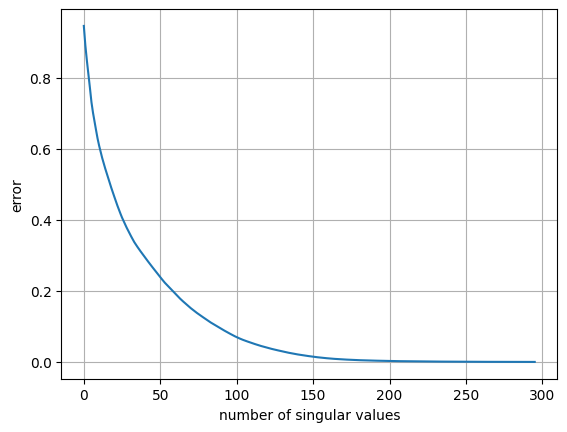

In [75]:
plt.plot(error_approximate)
plt.xlabel('number of singular values')
plt.ylabel('error');
plt.grid()